In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import nltk

from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, ImageColorGenerator

from textblob import TextBlob

from utils import stop_words, make_corpus_df, get_data_between_dates, get_data_by_year, get_data_by_channel, make_list_of_processed_snippets

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dylanlewis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dylanlewis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dylanlewis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## We start the sentiment and subjectivity analysis on the entire dataset analyzing differences between the networks

In [2]:
def polarity_classification(sentiment_score):
    if sentiment_score > 0.25:
        return 'positive'
    elif -0.25 <= sentiment_score <= 0.25:
        return 'neutral'
    else:
        return 'negative'

def subjectivity_classificiation(subjectivity_score):
    if subjectivity_score >= 0.5:
        return 'subjective'
    else:
        return 'objective'

def create_document(list_of_processed_snippets):
    return ' '.join(list_of_processed_snippets)

In [3]:
PARENT = 'TelevisionNewsV2'

In [4]:
corpus_df = make_corpus_df(PARENT)

In [5]:
corpus_df = corpus_df[['DateTime', 'Station', 'Show', 'IAShowID', 'Snippet']]
corpus_df['Snippet'] = make_list_of_processed_snippets(corpus_df, stop_words)

In [6]:
corpus_df['polarity'] = corpus_df.apply(lambda row: TextBlob(row['Snippet']).polarity, axis=1)
corpus_df['subjectivity'] = corpus_df.apply(lambda row: TextBlob(row['Snippet']).subjectivity, axis=1)
corpus_df['sentiment_class'] = corpus_df.apply(lambda row: polarity_classification(row['polarity']), axis=1)
corpus_df['subjectivity_class'] = corpus_df.apply(lambda row: subjectivity_classificiation(row['subjectivity']), axis=1)

In [7]:
corpus_df['Station'].unique()

array(['CNN', 'FOXNEWS', 'MSNBC'], dtype=object)

In [50]:
cnn_df, fox_df, msnbc_df = get_data_by_channel(corpus_df, 'CNN'), get_data_by_channel(corpus_df, 'FOXNEWS'), get_data_by_channel(corpus_df, 'MSNBC')

In [9]:
cnn_sentiment_counts = cnn_df['sentiment_class'].value_counts()
fox_sentiment_counts = fox_df['sentiment_class'].value_counts()
msnbc_sentiment_counts = msnbc_df['sentiment_class'].value_counts()

cnn_subjectivity_counts = cnn_df['subjectivity_class'].value_counts()
fox_subjectivity_counts = fox_df['subjectivity_class'].value_counts()
msnbc_subjectivity_counts = msnbc_df['subjectivity_class'].value_counts()

In [10]:
stations = ['CNN', 'Fox News', 'MSNBC']

list_sentiment_counts = [cnn_sentiment_counts, fox_sentiment_counts, msnbc_sentiment_counts]
positive_counts = [i['positive'] for i in list_sentiment_counts]
neutral_counts = [i['neutral'] for i in list_sentiment_counts]
negative_counts = [i['negative'] for i in list_sentiment_counts]

list_subjectivity_counts = [cnn_subjectivity_counts, fox_subjectivity_counts, msnbc_subjectivity_counts]
objective_counts = [i['objective'] for i in list_subjectivity_counts]
subjective_counts = [i['subjective'] for i in list_subjectivity_counts]

In [82]:
cnn_pos_neg_ratio = cnn_sentiment_counts['positive'] / cnn_sentiment_counts['negative']
print('CNN Pos / Neg Ratio: ', cnn_pos_neg_ratio)
fox_pos_neg_ratio = fox_sentiment_counts['positive'] / fox_sentiment_counts['negative']
print('Fox Pos / Neg Ratio: ', fox_pos_neg_ratio)
msnbc_pos_neg_ratio = msnbc_sentiment_counts['positive'] / msnbc_sentiment_counts['negative']
print('MSNBC Pos / Neg Ratio: ', msnbc_pos_neg_ratio)

CNN Pos / Neg Ratio:  3.5822306238185253
Fox Pos / Neg Ratio:  2.4168797953964196
MSNBC Pos / Neg Ratio:  3.3430079155672825


In [84]:
cnn_obj_subj_ratio = cnn_subjectivity_counts['objective'] / cnn_subjectivity_counts['subjective']
print('CNN Obj / Subj Ratio: ', cnn_obj_subj_ratio)
fox_obj_subj_ratio = fox_subjectivity_counts['objective'] / fox_subjectivity_counts['subjective']
print('Fox Obj / Subj Ratio: ', fox_obj_subj_ratio)
msnbc_obj_subj_ratio = msnbc_subjectivity_counts['objective'] / msnbc_subjectivity_counts['subjective']
print('MSNBC Obj / Subj Ratio: ', msnbc_obj_subj_ratio)

CNN Obj / Subj Ratio:  1.3305565616322588
Fox Obj / Subj Ratio:  1.417515655668754
MSNBC Obj / Subj Ratio:  1.439900295420975


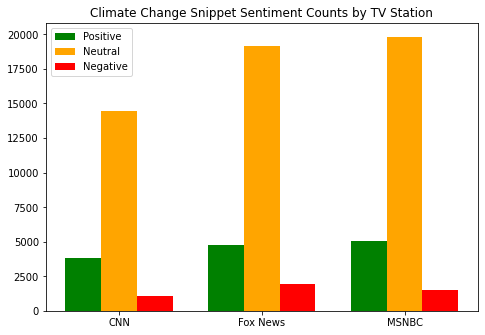

In [11]:
X = np.arange(3)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
width = 0.25

ax.bar(X + 0*width, positive_counts, color='g', width=width, label="Positive")
ax.bar(X + 1*width, neutral_counts, color='orange', width=width, label="Neutral")
ax.bar(X+ 2*width, negative_counts, color='r', width=width, label="Negative")
ax.set_title("Climate Change Snippet Sentiment Counts by TV Station")
ax.set_xticks(X + width)
ax.set_xticklabels(('CNN', 'Fox News', 'MSNBC'))
ax.legend()
plt.show()

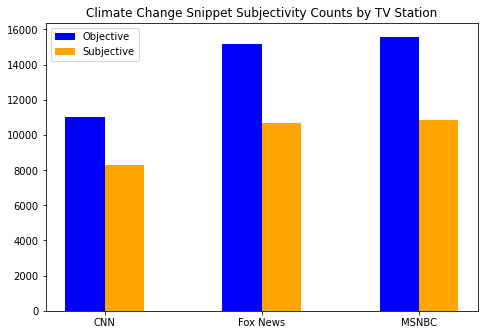

In [12]:
X = np.arange(3)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
width = 0.25

ax.bar(X + 0*width, objective_counts, color='blue', width=width, label="Objective")
ax.bar(X + 1*width, subjective_counts, color='orange', width=width, label="Subjective")
ax.set_title("Climate Change Snippet Subjectivity Counts by TV Station")
ax.set_xticks(X + width/2)
ax.set_xticklabels(('CNN', 'Fox News', 'MSNBC'))
ax.legend()
plt.show()

## This is where our use of TF-IDF comes in, we turn the snippets associated with each station into one document, yielding three documents. 
We use TF-IDF to hone in on which words were important to each network by using the TF-IDF statistic which is roughly found from the number of times a word appears in a document relative to the number of documents it appears in across the three document corpus.

We will also use this for words important to each year 

In [40]:
# documents_list is a list of strings, where each string is preprocessed document (e.g. preprocessed snippet).
def fit_tfidf_vectorizer(documents_list):
    vectorizer = TfidfVectorizer()
    vectorized_document_array = vectorizer.fit_transform(documents_list).toarray()
    features_array = np.array(vectorizer.get_feature_names())
    return vectorized_document_array, features_array

def get_top_tfidf_words_per_document(n, documents_list):
    vectorized_document_array, features_array = fit_tfidf_vectorizer(documents_list)
    num_docs = vectorized_document_array.shape[0]
    top_words_list = []
    # I.e. the words which had the largest tf-idf scores for document i will be the list located 
    # at index i in top_words_list in descending order of tf-idf score.
    for i in range(num_docs):
        doc_tfidf_vector = vectorized_document_array[i, :]
        top_tfidf_doc_indices = doc_tfidf_vector.argsort()[::-1]
        top_n_tfidf_words_for_doc = features_array[top_tfidf_doc_indices][:n]
        top_n_word_tfidf_scores_for_doc = np.sort(doc_tfidf_vector)[::-1][:n]
        top_n_words_tfidf_list_for_doc = [(word, tfidf) for word, tfidf in zip(top_n_tfidf_words_for_doc,                                                            top_n_word_tfidf_scores_for_doc)]
        top_words_list.append(top_n_words_tfidf_list_for_doc)
    return top_words_list


In [41]:
cnn_document = create_document(cnn_df['Snippet'].to_list())
fox_document = create_document(fox_df['Snippet'].to_list())
msnbc_document = create_document(msnbc_df['Snippet'].to_list())
network_doc_list = [cnn_document, fox_document, msnbc_document]

In [42]:
n = 30
top_n_words_tfidf_by_network = get_top_tfidf_words_per_document(n, network_doc_list)

In [44]:
cnn_top_n_words_tfidf, fox_top_n_words_tfidf, msnbc_top_n_words_tfidf = top_n_words_tfidf_by_network[0], top_n_words_tfidf_by_network[1], top_n_words_tfidf_by_network[2]

In [45]:
cnn_top_n_words_tfidf

[('president', 0.3669761109300874),
 ('issue', 0.21178391048482803),
 ('think', 0.21004390183060997),
 ('people', 0.1841923446822272),
 ('trump', 0.17507801363632303),
 ('world', 0.15022074714749345),
 ('know', 0.1491435989329775),
 ('right', 0.13588639013893505),
 ('year', 0.13464352681449357),
 ('new', 0.13414638148471697),
 ('state', 0.11210627186462141),
 ('country', 0.10995197543558952),
 ('time', 0.10672053079204168),
 ('he', 0.1066376732370789),
 ('gas', 0.10556052502256295),
 ('believe', 0.09536904576214283),
 ('scientist', 0.09503761554229177),
 ('greenhouse', 0.09180617089874392),
 ('thing', 0.09014901979948861),
 ('reporter', 0.08816043848038226),
 ('obama', 0.08799472337045672),
 ('crisis', 0.08666900249105247),
 ('deal', 0.08584042694142482),
 ('need', 0.08343755784750463),
 ('emission', 0.08095183119862168),
 ('question', 0.07838324699477595),
 ('united', 0.07722324122529724),
 ('real', 0.07672609589552064),
 ('today', 0.07523465990619087),
 ('big', 0.0737432239168611)]

In [47]:
fox_top_n_words_tfidf

[('president', 0.27673890487927133),
 ('people', 0.2538024786238606),
 ('think', 0.25154979390234705),
 ('know', 0.1724327759558558),
 ('issue', 0.16082803648139202),
 ('new', 0.1563909302117441),
 ('right', 0.151885560768717),
 ('year', 0.15045203412775382),
 ('world', 0.12908566086006465),
 ('gas', 0.12137192226821521),
 ('time', 0.1165252369582921),
 ('obama', 0.10867497201968425),
 ('bill', 0.10812886663265067),
 ('believe', 0.10205344420190199),
 ('state', 0.1014390756414892),
 ('country', 0.09823070649266687),
 ('greenhouse', 0.09747981158549568),
 ('say', 0.08894691491309584),
 ('trump', 0.08846907269944146),
 ('thing', 0.08785470413902867),
 ('deal', 0.0858068089376527),
 ('american', 0.08539722989737751),
 ('threat', 0.08512417720386072),
 ('democrat', 0.08177928170827999),
 ('tax', 0.0813014394946256),
 ('need', 0.07768349130552807),
 ('talking', 0.07700085957173608),
 ('problem', 0.0758403856242897),
 ('big', 0.07481643802360172),
 ('emission', 0.07331464820925936)]

In [48]:
msnbc_top_n_words_tfidf

[('president', 0.2789340404141205),
 ('think', 0.2500872246657715),
 ('people', 0.2185512989747798),
 ('issue', 0.21506767927635628),
 ('know', 0.16727486165938824),
 ('right', 0.15657953802387747),
 ('republican', 0.14117827198874197),
 ('new', 0.13476107780743551),
 ('year', 0.1314608065141922),
 ('country', 0.12376017349662446),
 ('state', 0.12082659901374151),
 ('trump', 0.11911534723205978),
 ('time', 0.11795414066591862),
 ('believe', 0.11190364329497254),
 ('world', 0.11184252715991248),
 ('he', 0.10285845530608344),
 ('gas', 0.10120831965946178),
 ('thing', 0.09344657050683397),
 ('need', 0.08898509264744948),
 ('science', 0.08886286037732936),
 ('today', 0.08544035681396593),
 ('there', 0.08537924067890586),
 ('energy', 0.08434026638288482),
 ('greenhouse', 0.0837291050322842),
 ('real', 0.0834235243569839),
 ('big', 0.0818345048454223),
 ('obama', 0.07902316263265947),
 ('talking', 0.07645628496013689),
 ('american', 0.07468391704339511),
 ('care', 0.07450056863821493)]

TF-IDF
	The TF-IDF statistic provides an effective way to hone in on words that are important for a document (snippets or set of snippets) while also taking into account how prevalent a word is across all the documents in a corpus. We construct our documents at different levels of granularity to uncover the most important words to each document, namely we have looked at the TF-IDF when the documents are the entirety of the snippets for a given network, i.e. one document for CNN snippets, one document for Fox News snippets, and another for MSNBC snippets. After constructing the TF-IDF featurization for our documents, for each document, we select the words which had the top 30 largest TF-IDF scores. At the level of the TV networks, we find that the most interesting finding is that  CNN & MSNBC which are more liberal-leaning networks have a higher TF-IDF score for Trump than FOX does which is conservative-leaning network. Additionally, Fox News has a higher TF-IDF score for Obama than 

### We now do a similar process of applying TF-IDF featurization by year (11 documents), this will uncover what words were important to each year. For 2009-2018, we construct a document for each year the same way, by filtering the DF by year, except 2019-2020, since 2020 only has January data, so we combine 2019 + 2020 as a single document


In [59]:
first_10_years_documents = [create_document(get_data_by_year(corpus_df, year)['Snippet'].tolist()) for year in range(2009, 2019)]
_2019_data = get_data_by_year(corpus_df, 2019)
_2020_data = get_data_by_year(corpus_df, 2020)
final_years_df = pd.concat([_2019_data, _2020_data])
final_years_document = create_document(final_years_df['Snippet'].tolist())

In [69]:
all_years_documents = first_10_years_documents + [final_years_document]
years = [str(year) for year in range(2009, 2019)]
years.append('2019 & 2020')

In [78]:
n = 30
top_n_words_tfidf_by_year = get_top_tfidf_words_per_document(n, all_years_documents)

In [80]:
for year_i, top_n_words_year_i in zip(years, top_n_words_tfidf_by_year):
    print('In the year {}, we find the top {} words with highest tf-idf scores are: \n'.format(year_i, n))
    print(list(map(lambda x: x[0], top_n_words_year_i)))
    print('\n')

In the year 2009, we find the top 30 words with highest tf-idf scores are: 

['president', 'copenhagen', 'gas', 'greenhouse', 'think', 'people', 'world', 'obama', 'bill', 'emission', 'year', 'right', 'know', 'issue', 'email', 'new', 'country', 'time', 'scientist', 'health', 'summit', 'energy', 'debate', 'next', 'care', 'nation', 'conference', 'state', 'today', 'believe']


In the year 2010, we find the top 30 words with highest tf-idf scores are: 

['people', 'think', 'bill', 'know', 'fiftyton', 'energy', 'right', 'president', 'year', 'country', 'new', 'lightest', 'gas', 'time', 'republican', 'legislation', 'issue', 'greenhouse', 'america', 'tallest', 'environment', 'tax', 'gore', 'big', 'al', 'facing', 'nation', 'house', 'barely', 'question']


In the year 2011, we find the top 30 words with highest tf-idf scores are: 

['think', 'know', 'believe', 'right', 'people', 'republican', 'gas', 'issue', 'greenhouse', 'gingrich', 'president', 'year', 'he', 'romney', 'newt', 'new', 'perry', 's

After finding the top 30 words by tf-idf score per year, we see some topical events emerge by year. We discuss this by year when using the top 30 tf-idf scores and assciated words in each year:

### 2009
In 2009, we see Copenhagen, Obama, 
